In [3]:
# import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import math
import os

The `Layer` class, which is one of the main components of the KAN or Kolmogorov-Arnold Networks, implements a neural network layer using B-spline bases.

### Functions and Variables of the `Layer` Class

#### Input Variables and Initial Settings
- **in_features and out_features**: Number of input and output features of the layer.
- **grid_size**: Number of grid points.
- **spline_order**: Order of B-spline.
- **scale_noise, scale_base, and scale_spline**: Scales for noise, base weights, and spline weights.
- **enable_standalone_scale_spline**: Whether standalone scaling for spline is enabled or not.
- **base_activation**: Base activation function, default is `SiLU`.
- **grid_eps and grid_range**: Grid settings, including grid range and blending parameter for adaptive and uniform grids.

#### Initial Settings and Definition of Learnable Variables
In this section, learnable variables and other initial settings are defined.
- **Define and Register Network**: The base network and spline weights are defined and registered as learnable parameters.
- **Define and Register Adaptive Network**: If enabled, spline scaling is also defined as a learnable parameter.
- **Define Network and Activation Settings**: Settings related to noise, scaling, and base activation function are configured.

#### Functions `reset_parameters`, `b_splines`, and `curve2coeff`
These functions are used for initial parameter setup, calculation of B-spline bases, and calculation of curve coefficients that interpolate data points using B-spline bases.

#### Function `scaled_spline_weight`
This function calculates and returns the scaled spline weights.

#### Function `forward`
This function implements the forward operation in the layer. First, the base output is computed using a linear transformation, then the spline output is computed using the spline weights, and finally, these two outputs are summed.

#### Function `update_grid`
This function is used to update the grid based on the inputs and create an adaptive and uniform grid.

#### Function `regularization_loss`
This function calculates the regularization loss, which includes L1 loss for spline weights and an entropy regularization term.

### Additional Explanations

#### B-spline Functions and Curve Coefficients
- **b_splines**: This function calculates B-spline bases for a given input.
- **curve2coeff**: This function calculates the curve coefficients that interpolate input data points using B-spline bases.

#### Function `forward` Operation
- **Base Output**: Computed using a linear transformation and base activation function.
- **Spline Output**: Computed using B-spline bases and spline weights.
- **Sum of Outputs**: The base output and spline output are summed and returned as the final output.

#### Network Update
- **update_grid**: This function updates the network based on the inputs and creates a new adaptive and uniform grid.

#### Regularization Loss
- **regularization_loss**: This function includes L1 loss and an entropy regularization term used to control and prevent model over-complexity.


In this section, we explain the code for the `KAN` class, which implements the Kolmogorov-Arnold Networks. This network consists of several layers of the `Layer` type described previously.

### Functions and Variables of the `KAN` Class

#### Input Variables and Initial Settings
- **layers_hidden**: A list of sizes for the hidden layers.
- **grid_size**: Grid size for splines.
- **spline_order**: Order of splines.
- **scale_noise**: Noise scaling factor.
- **scale_base**: Base scaling factor.
- **scale_spline**: Spline scaling factor.
- **base_activation**: Activation function for the base layer, default is `SiLU`.
- **grid_eps**: Blending factor for adaptive and uniform grids.
- **grid_range**: Range of grid values.

#### Initial Settings and Definition of Layers
In this section, the network layers are initialized based on the sizes specified in `layers_hidden`.
- **Define Layers**: The network layers are defined using the `Layer` class and added to `ModuleList`.

#### Function `forward`
This function implements the forward pass through the network. Here, the input is passed through each layer, and if necessary, the network is updated.

##### Explanation of Function `forward`
- **Input `x`**: The input tensor that is fed into the network.
- **Option `update_grid`**: If this option is enabled, the network is updated based on the input at each layer.
- **Passing Through Layers**: The input is passed through each layer, and the final output of the network is returned.

#### Function `regularization_loss`
This function calculates the total regularization loss for the entire network. This loss includes activation and entropy losses.

##### Explanation of Function `regularization_loss`
- **Weights `regularize_activation` and `regularize_entropy`**: These weights are used to adjust the impact of activation and entropy losses.
- **Sum of Losses**: The sum of regularization losses from each layer is computed and returned.


In [4]:
class Layer(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        #store the input parameters in the instance variables
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        #caculate the grid size (h)
        h = (grid_range[1] - grid_range[0]) / grid_size

        #create a grid tensor
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())

        #grid registered as a buffer,won't update during backpropogation
        self.register_buffer("grid", grid)

        #define learnable parameters spline weight and base
        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))

        #defien optionally for the spline scaler
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        #store parameters for scaling and activation functions
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        #calling reset parameters for initialize weights
        self.reset_parameters()


    def reset_parameters(self):\
        #initialize the base weight with kaiming uniform distribution
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)

        #generate noise for the spline weight
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            #initialize the spline scaler if enabled
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    #compute B-spline bases for the given input tensor
    def b_splines(self, x: torch.Tensor):

      # Ensure the input tensor x has 2 dimensions and its second dimension matches the expected number of input features
      if x.dim() != 2 or x.size(1) != self.in_features:
            raise ValueError(f"Expected x to have 2 dimensions and size(1) to be {self.in_features}, but got dimensions {x.dim()} and size(1) {x.size(1)}")


      # Retrieve the pre-defined grid tensor which includes the grid points for the splines
      grid: torch.Tensor = self.grid  # (in_features, grid_size + 2 * spline_order + 1)

      # Add an additional dimension to x to facilitate broadcasting in the following computations
      x = x.unsqueeze(-1)

      # Initialize the bases tensor by checking if x falls within the intervals defined by grid points
      bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)

      # Iteratively compute the B-spline bases of increasing order
      for k in range(1, self.spline_order + 1):
          # Calculate the left and right terms of the B-spline recursive formula
          left_term = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * bases[:, :, :-1]
          right_term = (grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * bases[:, :, 1:]

          # Update the bases tensor by summing the left and right terms
          bases = left_term + right_term

      # Ensure the final shape of the bases tensor is as expected
      expected_size = (x.size(0), self.in_features, self.grid_size + self.spline_order)
      if bases.size() != expected_size:
          raise ValueError(f"Expected bases to have size {expected_size}, but got {bases.size()}")

      # Return the bases tensor in contiguous memory format
      return bases.contiguous()

    # compute the coefficients of the curve that interpolates the given points, using B-spline basis functions
    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
      # Ensure the input tensor x has 2 dimensions and its second dimension matches the expected number of input features
      if not (x.dim() == 2 and x.size(1) == self.in_features):
          raise ValueError(f"Expected x to have 2 dimensions and size(1) to be {self.in_features}, but got dimensions {x.dim()} and size(1) {x.size(1)}")

      # Ensure the output tensor y has the correct shape corresponding to x and the expected number of output features
      expected_size = (x.size(0), self.in_features, self.out_features)
      if y.size() != expected_size:
          raise ValueError(f"Expected y to have size {expected_size}, but got {y.size()}")

      # Compute the B-spline bases for x and transpose the result for further computations
      A = self.b_splines(x).transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)

      # Transpose y to align dimensions with A for the least squares computation
      B = y.transpose(0, 1)  # (in_features, batch_size, out_features)

      # Solve the linear least squares problem to find the spline coefficients
      solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)

      # Permute the solution tensor to match the expected output shape
      result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

      # Ensure the resulting tensor has the correct shape
      if result.size() != (self.out_features, self.in_features, self.grid_size + self.spline_order):
          raise ValueError(f"Expected size {(self.out_features, self.in_features, self.grid_size + self.spline_order)}, but got {result.size()}")

      # Return the result tensor in contiguous memory format
      return result.contiguous()

    @property
    def scaled_spline_weight(self):
        """
        Property to compute the scaled spline weights.

        Returns:
            torch.Tensor: Scaled spline weights, optionally modified by a scaler tensor.
        """
        # Return the spline weight scaled by spline_scaler if standalone scaling is enabled, otherwise return the spline weight as is
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        """
        Forward pass through the layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor after applying the base and spline transformations.
        """
        # Ensure the input tensor x has 2 dimensions and its second dimension matches the expected number of input features
        if x.dim() != 2 or x.size(1) != self.in_features:
            raise ValueError(f"Expected x to have 2 dimensions and size(1) to be {self.in_features}, but got dimensions {x.dim()} and size(1) {x.size(1)}")

        # Compute the base output using a linear transformation of the base activation
        base_output = F.linear(self.base_activation(x), self.base_weight)

        # Compute the spline output by applying the spline weights to the B-spline bases
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )

        # Return the sum of the base output and the spline output
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        """
        Update the grid based on the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            margin (float): Margin to be added to the grid range.

        Updates:
            self.grid: Updates the grid with new adaptive and uniform grid points.
        """
        # Ensure the input tensor x has 2 dimensions and its second dimension matches the expected number of input features
        if x.dim() != 2 or x.size(1) != self.in_features:
                    raise ValueError(f"Expected x to have 2 dimensions and size(1) to be {self.in_features}, but got dimensions {x.dim()} and size(1) {x.size(1)}")
        batch = x.size(0)

        # Compute the B-spline bases for x and permute the result
        splines = self.b_splines(x).permute(1, 0, 2)  # (in_features, batch_size, grid_size + spline_order)

        # Permute the scaled spline weights for matrix multiplication
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)  # (in_features, grid_size + spline_order, out_features)

        # Compute the unreduced spline output
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)  # (batch_size, in_features, out_features)

        # Sort each channel of x individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]

        # Create an adaptive grid based on the sorted values of x
        grid_adaptive = x_sorted[
            torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)
        ]

        # Calculate a uniform step and create a uniform grid
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1)
            * uniform_step + x_sorted[0] - margin
        )

        # Combine the adaptive and uniform grids using a blending factor grid_eps
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive

        # Extend the grid with additional points for spline order
        grid = torch.cat(
            [grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
             grid,
             grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),],
            dim=0,
        )

        # Update the grid and the spline weights
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Args:
            regularize_activation (float): Weight for the activation regularization.
            regularize_entropy (float): Weight for the entropy regularization.

        Returns:
            torch.Tensor: Regularization loss value.
        """
        # Compute the mean absolute value of the spline weights (L1 regularization)
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()

        # Compute the entropy regularization term
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())

        # Return the combined regularization loss
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
        def __init__(
            self,
            layers_hidden,
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        ):
            """
            Initialize the Kolmogorov-Arnold Network (KAN).

            Args:
                layers_hidden (list): List of hidden layer sizes.
                grid_size (int): Size of the grid for splines.
                spline_order (int): Order of the splines.
                scale_noise (float): Noise scale factor.
                scale_base (float): Base scale factor.
                scale_spline (float): Spline scale factor.
                base_activation (torch.nn.Module): Activation function for the base layer.
                grid_eps (float): Blending factor for adaptive and uniform grids.
                grid_range (list): Range of the grid values.
            """
            super(KAN, self).__init__()
            self.grid_size = grid_size
            self.spline_order = spline_order

            # Initialize the layers of the network
            self.layers = torch.nn.ModuleList()
            for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
                self.layers.append(
                    Layer(
                        in_features,
                        out_features,
                        grid_size=grid_size,
                        spline_order=spline_order,
                        scale_noise=scale_noise,
                        scale_base=scale_base,
                        scale_spline=scale_spline,
                        base_activation=base_activation,
                        grid_eps=grid_eps,
                        grid_range=grid_range,
                    )
                )

        def forward(self, x: torch.Tensor, update_grid=False):
            """
            Forward pass through the KAN.

            Args:
                x (torch.Tensor): Input tensor.
                update_grid (bool): Flag to update the grid based on the input.

            Returns:
                torch.Tensor: Output tensor.
            """
            # Pass the input through each layer, updating the grid if specified
            for layer in self.layers:
                if update_grid:
                    layer.update_grid(x)
                x = layer(x)
            return x

        def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
            """
            Compute the total regularization loss for the network.

            Args:
                regularize_activation (float): Weight for the activation regularization.
                regularize_entropy (float): Weight for the entropy regularization.

            Returns:
                torch.Tensor: Total regularization loss value.
            """
            # Sum the regularization loss from each layer
            return sum(
                layer.regularization_loss(regularize_activation, regularize_entropy)
                for layer in self.layers
            )


In this section, we explain the code related to loading MNIST data, defining the KAN model, and the training and evaluation process.

### Data Loading

#### Data Preparation
- **Data Transformation**: Data is converted to tensors and normalized using `transforms.Compose`. Normalization scales pixel values to the range [-1, 1], which is suitable for training neural networks.
- **Training and Validation Datasets**: MNIST datasets for training (`train=True`) and validation (`train=False`) are downloaded and loaded.
- **Data Loaders**: `DataLoader` objects are used to load data in batches of 64 for training and validation.

### Model Definition

#### Defining the KAN Model
- **KAN Network Definition**: The KAN model is defined with hidden layers [784, 64, 10]. Inputs are 28x28 images (converted to 784-dimensional vectors), the middle layer has 64 neurons, and the output layer has 10 classes (for digits 0 to 9).
- **Transfer to Computation Device**: The model is transferred to the appropriate computation device (GPU if available, otherwise CPU).

### Optimizer, Learning, and Loss Function Settings

#### Optimizer and Its Settings
- **AdamW Optimizer**: The AdamW optimizer is used to update the model weights. The learning rate is set to `1e-3` and weight decay is set to `1e-4`.
- **Learning Rate Scheduler**: The `ExponentialLR` scheduler is used to decay the learning rate exponentially over epochs with a factor of `0.8`.

#### Loss Function
- **CrossEntropyLoss Function**: The loss function used to evaluate the model’s error in digit classification.

### Training Loop

#### Model Training
- **Model Training Mode**: The model is set to training mode (`train()`).
- **Training Loop**: Training data is loaded from `trainloader` and the following operations are performed:
  - **Image Preprocessing**: Images are converted to 784-dimensional vectors and transferred to the computation device.
  - **Gradient Zeroing**: Gradients of the optimizer are zeroed.
  - **Prediction and Error Calculation**: Model output is computed, and error is calculated using the loss function.
  - **Gradient Calculation and Update**: Gradients are calculated and model weights are updated.
  - **Accuracy Calculation**: Model accuracy is computed based on outputs and true labels.
  - **Progress Display**: Training progress is displayed using `tqdm`.

### Validation Loop

#### Model Evaluation
- **Model Evaluation Mode**: The model is set to evaluation mode (`eval()`).
- **Evaluation Loop**: Validation data is loaded from `valloader` and the following operations are performed:
  - **Image Preprocessing**: Images are converted to 784-dimensional vectors and transferred to the computation device.
  - **Prediction and Error Calculation**: Model output is computed, and error is calculated using the loss function.
  - **Accuracy Calculation**: Model accuracy is computed based on outputs and true labels.
  - **Result Collection**: Error and accuracy results are collected and averaged.

### Learning Rate Update and Results Display

- **Learning Rate Update**: The learning rate is updated using the `scheduler`.

- **Results Display**: Model error and accuracy on the validation dataset are printed for each epoch.


In [ ]:
# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Define model
model = KAN([28 * 28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()
for epoch in range(2):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17663290.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 496510.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4393008.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8366503.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 938/938 [00:48<00:00, 19.24it/s, accuracy=0.969, loss=0.168, lr=0.001]


Epoch 1, Val Loss: 0.2279974632795639, Val Accuracy: 0.9358081210191083


100%|██████████| 938/938 [00:46<00:00, 20.09it/s, accuracy=0.906, loss=0.281, lr=0.0008]


Epoch 2, Val Loss: 0.15911019734065435, Val Accuracy: 0.9511345541401274


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define the function f(x, y) = 2xy
def f(x, y):
    return 2 * x * y

# Generate dataset
def generate_dataset(n_samples=1000):
    x = np.random.uniform(-2, 2, n_samples)
    y = np.random.uniform(-2, 2, n_samples)
    z = f(x, y)
    return x, y, z

x, y, z = generate_dataset()

# Prepare dataset for training
dataset = TensorDataset(torch.tensor(x, dtype=torch.float32).unsqueeze(1),
                        torch.tensor(y, dtype=torch.float32).unsqueeze(1),
                        torch.tensor(z, dtype=torch.float32).unsqueeze(1))
trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define KAN model for 2 input features (x, y) and 1 output feature (z)
model = KAN([2, 64, 1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for i, (x_batch, y_batch, z_batch) in enumerate(trainloader):
        inputs = torch.cat((x_batch, y_batch), dim=1).to(device)
        targets = z_batch.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 0.0091
Epoch [100/500], Loss: 0.0052
Epoch [150/500], Loss: 0.0029
Epoch [200/500], Loss: 0.0008
Epoch [250/500], Loss: 0.0011
Epoch [300/500], Loss: 0.0005
Epoch [350/500], Loss: 0.0002
Epoch [400/500], Loss: 0.0002
Epoch [450/500], Loss: 0.0002
Epoch [500/500], Loss: 0.0002


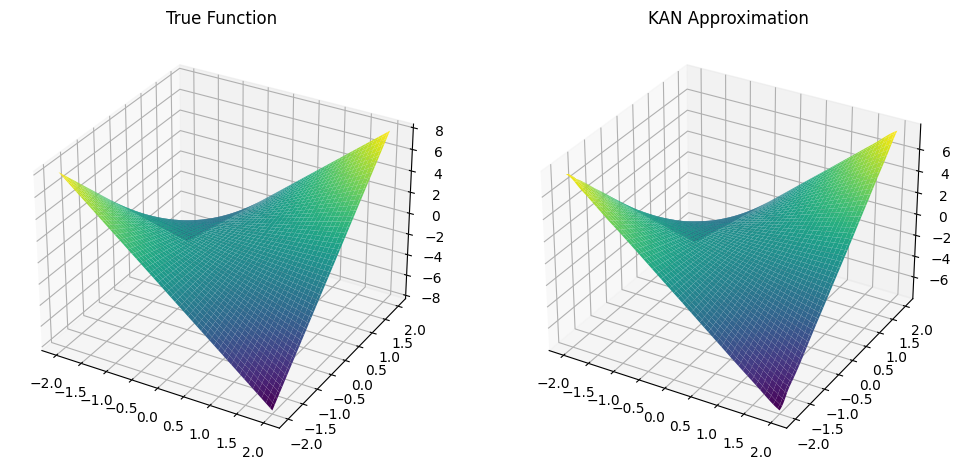

In [20]:
# Visualization of function approximation
def visualize_approximation(model, n_points=100):
    model.eval()
    x = np.linspace(-2, 2, n_points)
    y = np.linspace(-2, 2, n_points)
    X, Y = np.meshgrid(x, y)
    Z_true = f(X, Y)

    X_flat = X.flatten()
    Y_flat = Y.flatten()
    inputs = torch.tensor(np.vstack((X_flat, Y_flat)).T, dtype=torch.float32).to(device)
    with torch.no_grad():
        Z_pred = model(inputs).cpu().numpy().reshape(X.shape)

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z_true, cmap='viridis')
    ax1.set_title('True Function')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, Z_pred, cmap='viridis')
    ax2.set_title('KAN Approximation')

    plt.show()

visualize_approximation(model)

In [23]:
# Define the function f(x) = x^3 + 2x^2
def f(x):
    return x**3+ 2*x**2 + 1

# Generate dataset
def generate_dataset(n_samples=1000):
    x = np.random.uniform(-5, 5, n_samples)
    y = f(x)
    return x, y

x, y = generate_dataset()

# Prepare dataset for training
dataset = TensorDataset(torch.tensor(x, dtype=torch.float32).unsqueeze(1),
                        torch.tensor(y, dtype=torch.float32).unsqueeze(1))
trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define KAN model for 1 input feature (x) and 1 output feature (f(x))
class SimpleKAN(nn.Module):
    def __init__(self, layers_hidden):
        super(SimpleKAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(nn.Linear(in_features, out_features))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

model = SimpleKAN([1, 64, 64, 1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for i, (x_batch, y_batch) in enumerate(trainloader):
        inputs = x_batch.to(device)
        targets = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [50/500], Loss: 88.3186
Epoch [100/500], Loss: 10.6029
Epoch [150/500], Loss: 0.7069
Epoch [200/500], Loss: 0.4252
Epoch [250/500], Loss: 0.3043
Epoch [300/500], Loss: 0.0296
Epoch [350/500], Loss: 0.0522
Epoch [400/500], Loss: 0.0301
Epoch [450/500], Loss: 0.0483
Epoch [500/500], Loss: 0.0267


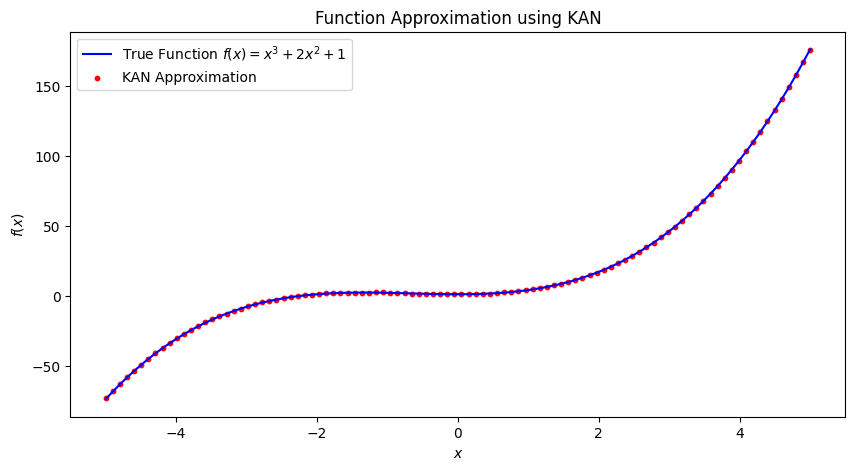

In [24]:
# Visualization of function approximation
def visualize_approximation(model, n_points=100):
    model.eval()

    # Generate test data
    x_test = np.linspace(-5, 5, n_points)
    y_true = f(x_test)

    # Convert test data to tensor and move to device
    x_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Get model predictions
    with torch.no_grad():
        y_pred = model(x_tensor).cpu().numpy()

    # Plot true function and model predictions
    plt.figure(figsize=(10, 5))
    plt.plot(x_test, y_true, label='True Function $f(x) = x^3 + 2x^2 + 1$', color='blue')
    plt.scatter(x_test, y_pred, label='KAN Approximation', color='red', s=10)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.title('Function Approximation using KAN')
    plt.legend()
    plt.show()

# Call the function to visualize the approximation
visualize_approximation(model)